# Part 1 - Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model

### Importing the dataset

In [3]:
dataset = pd.read_excel('Peak_Incident_Pressure.xlsx')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Charge_mass        576 non-null    float64
 1   Standoff_distance  576 non-null    int64  
 2   Peak_Pressure      576 non-null    float64
 3   Peak_time          576 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 18.1 KB


In [4]:
y = dataset['Peak_Pressure']
X = dataset.drop(['Peak_time','Peak_Pressure'], axis=1)
print(X.shape, y.shape)

(576, 2) (576,)


In [5]:
# convert to numpy array
X = np.array(X)
y = np.array(y)

### Splitting the dataset into the Training set and Test set

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 0)

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size = 0.5,
                                                random_state = 0)

# Part 2 - Building the ANN

### Initializing the ANN

In [10]:
ann = tf.keras.models.Sequential()

### Adding the input layer and the first hidden layer

In [11]:
ann.add(tf.keras.layers.Dense(units=250,
                              input_shape=(X_train.shape[1],),
                              activation='relu'))

### Adding the second hidden layer

In [12]:
ann.add(tf.keras.layers.Dense(units=185,
                              activation='relu'))

### Adding the third hidden layer

In [13]:
ann.add(tf.keras.layers.Dense(units=120,
                              activation='relu'))

### Adding the output layer

In [14]:
ann.add(tf.keras.layers.Dense(units=1,
                              activation='linear'))

### what model looks like

In [15]:
ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 250)               750       
                                                                 
 dense_2 (Dense)             (None, 185)               46435     
                                                                 
 dense_3 (Dense)             (None, 120)               22320     
                                                                 
 dense_4 (Dense)             (None, 1)                 121       
                                                                 
Total params: 69,626
Trainable params: 69,626
Non-trainable params: 0
_________________________________________________________________


# Part 3 - Training the ANN

### Compiling the ANN

In [16]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
ann.compile(optimizer = opt,
            loss = 'mean_squared_error',
            metrics = ['mae'])

### early stopping callback

In [17]:
# protects from unnecessary further training of the model if a particular metric does not continue to improve over a number of n epochs. In such a case, the model training would be automatically aborted.
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

### Training the ANN model on the Training set

In [18]:
history = ann.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    callbacks=[es],
                    epochs=400,
                    batch_size=30,
                    verbose=1)

Epoch 1/400
14/14 [==============================] - 1s 20ms/step - loss: 2171082637312.0000 - mae: 506907.7500 - val_loss: 1651532365824.0000 - val_mae: 468760.8438
Epoch 2/400
14/14 [==============================] - 0s 6ms/step - loss: 2171018412032.0000 - mae: 506839.2500 - val_loss: 1651439566848.0000 - val_mae: 468620.9688
Epoch 3/400
14/14 [==============================] - 0s 6ms/step - loss: 2170819837952.0000 - mae: 506614.3438 - val_loss: 1651180175360.0000 - val_mae: 468208.9375
Epoch 4/400
14/14 [==============================] - 0s 6ms/step - loss: 2170350075904.0000 - mae: 506014.3438 - val_loss: 1650547359744.0000 - val_mae: 467160.3125
Epoch 5/400
14/14 [==============================] - 0s 6ms/step - loss: 2169332957184.0000 - mae: 504571.9375 - val_loss: 1649185521664.0000 - val_mae: 464831.3438
Epoch 6/400
14/14 [==============================] - 0s 6ms/step - loss: 2167217586176.0000 - mae: 501512.7812 - val_loss: 1646510342144.0000 - val_mae: 460161.1562
Epoch 7/4

### Analyse learn history

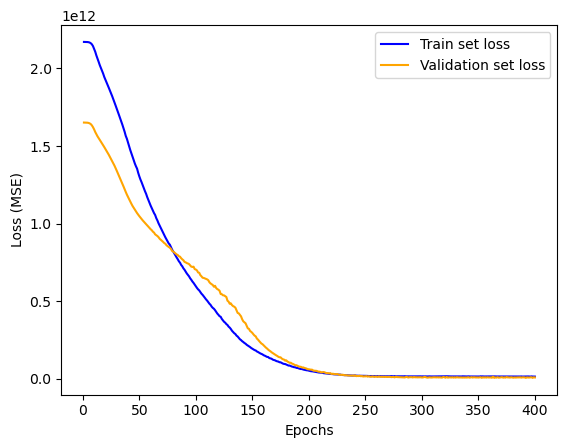

In [19]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'blue', label='Train set loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation set loss')
#plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

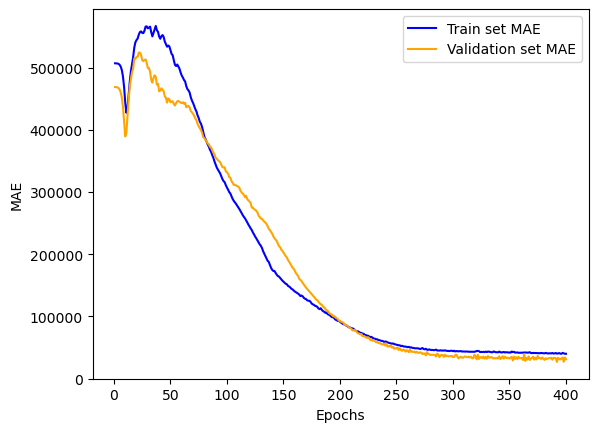

In [20]:
loss_values1 = history_dict['mae'] # you can change this
val_loss_values1 = history_dict['val_mae'] # you can also change this
epochs = range(1, len(loss_values1) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values1, 'blue', label='Train set MAE')
plt.plot(epochs, val_loss_values1, 'orange', label='Validation set MAE')
#plt.title('Training and testing MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [21]:
print (epochs)

range(1, 401)


### Save the model

In [38]:
ann.save('Peak_Pressure_ANN_model_2.h5')

# Part 4 - Make predictions

3/3 [==============================] - 0s 2ms/step


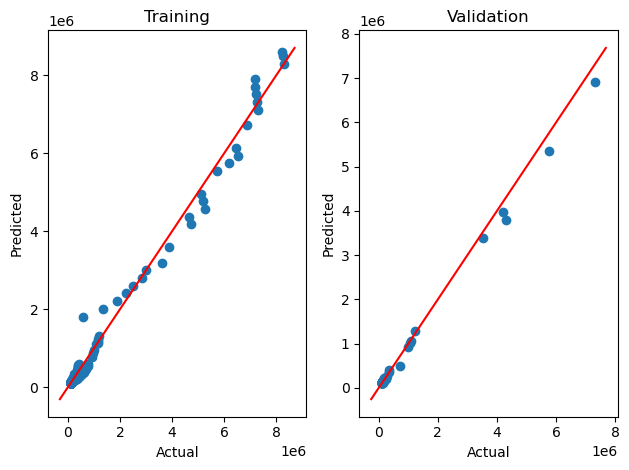

In [22]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=ann.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_val, y=ann.predict(X_val)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [23]:
#X_test=np.asarray(X_test).astype(np.int)

#y_test=np.asarray(y_test).astype(np.int)

y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

3/3 [==============================] - 0s 4ms/step
[[ 112166.93  118368.74]
 [ 144858.45  137823.75]
 [ 110839.69  104146.02]
 [ 305344.78  502720.97]
 [ 126473.34  111979.  ]
 [ 122917.42  111998.  ]
 [ 111191.13  110905.95]
 [ 115466.51  116917.54]
 [ 680183.    843974.25]
 [ 110442.75  105965.99]
 [ 122975.28  128049.96]
 [ 123049.73  110195.  ]
 [ 121271.76  110347.  ]
 [ 109810.12  109702.34]
 [ 113308.16  104562.03]
 [ 183923.75  230325.69]
 [ 118493.16  123607.26]
 [ 174384.8   187806.86]
 [ 113440.48  103316.98]
 [ 123372.23  125288.82]
 [ 268081.34  439089.91]
 [ 129896.93  113668.4 ]
 [ 113043.53  106026.18]
 [ 107296.15  113447.05]
 [ 145198.17  121033.56]
 [ 118964.55  112545.12]
 [6527041.5  6368836.  ]
 [ 819078.69  937022.19]
 [ 109074.12  114483.16]
 [ 110707.38  104858.24]
 [ 122520.47  115248.66]
 [ 156593.91  141438.27]
 [ 127722.04  126701.  ]
 [ 116202.52  107839.  ]
 [ 326099.38  236178.17]
 [ 113233.73  111111.18]
 [ 112630.03  118001.59]
 [ 194568.69  175230.08]

Text(0, 0.5, 'Predicted data')

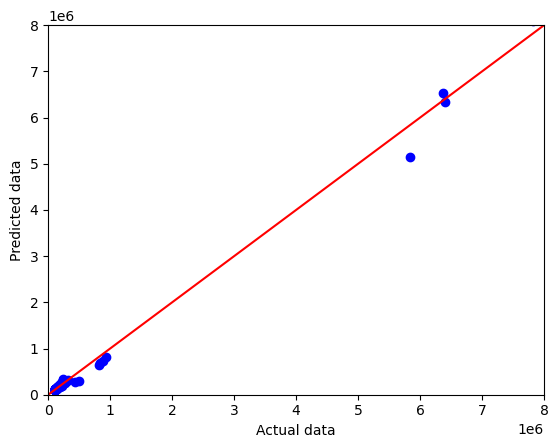

In [37]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, color="blue")
plt.plot ([0,8000000],[0,8000000], color = "red")
plt.axis ([0,8000000,0,8000000])
plt.xlabel ('Actual data')
plt.ylabel ('Predicted data')

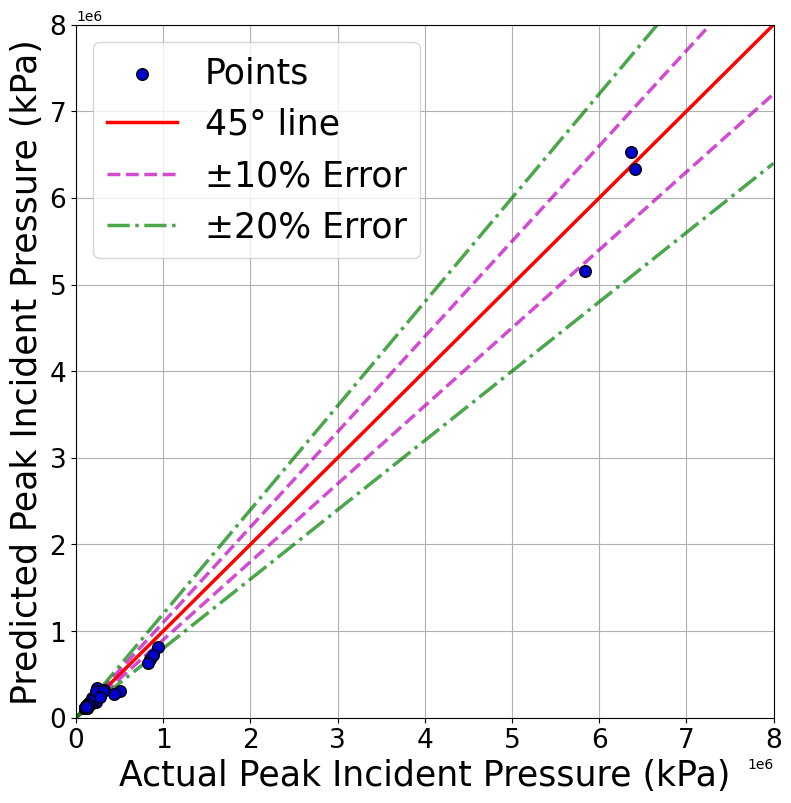

In [28]:
from sklearn.metrics import r2_score
# Initialize layout
fig1, ax1 = plt.subplots(figsize = (9, 9))


#y = y_pred         # Model on prvious line is called here
#x = y_test



# Add scatterplot
ax1.scatter(y_test, y_pred, s=70, alpha=1, edgecolors="k",c='mediumblue',zorder=5, label = 'Points')


plt.ylabel('Predicted Peak Incident Pressure (kPa)',fontsize = 25)
plt.xlabel('Actual Peak Incident Pressure (kPa)',fontsize = 25)
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)


x1 = np.linspace(0,8000000)

plt.plot(x1, x1, 'Red', label='45\N{DEGREE SIGN} line',lw=2.5,alpha=1)
plt.plot(x1, 1.1*x1, '--m', label='\u00B110% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.9*x1,'m', linestyle='--',lw=2.5,alpha=0.7)
plt.plot(x1, 1.2*x1, '-.g', label='\u00B120% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.8*x1,'-.g',lw=2.5,alpha=0.7)

plt.ylim(0, 8000000)
plt.xlim(0, 8000000)
plt.legend(loc='upper left',fontsize = 25)

plt.grid()

ax1.spines['left'].set_color('black')        # setting up Y-axis tick color to red
ax1.spines['bottom'].set_color('black')         #setting up above X-axis tick color to red



#ax1.annotate("$R^2$ = {:.3f}".format(r2), (2500, 1000),fontsize = 25)  #Model is called here
#ax1.annotate("Adj.$R^2$ = {:.3f}".format(adj_r2), (2500, 750),fontsize = 25)

#plt.savefig('plot1.png', dpi = 600, bbox_inches = 'tight')

In [29]:
# metrics


trainpreds = ann.predict(X_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train
print(mean_absolute_error(y_test, y_pred)) # test

13/13 [==============================] - 0s 2ms/step
39656.39463808933
35376.724587040226


In [30]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print (r2)

0.99516685270678


In [31]:
r2_train = r2_score(y_train, trainpreds)
print (r2_train)

0.9924073192652536


In [32]:
count1 = 0
for i in range(len(y_pred)):
    line1 = y_pred[i] - 0.9*y_test[i]
    line2 = y_pred[i] - 1.1*y_test[i]
    #print ('line 1 ', line1)
    #print ('line 2 ', line2)
    mask1 = (line1 > 0) & (line2 < 0)
    #print (mask)
    count1 = np.sum(mask1+count1)
    #print (count)

count2 = 0
for j in range(len(y_pred)):
    line3 = y_pred[j] - 0.8*y_test[j]
    line4 = y_pred[j] - 1.2*y_test[j]
    mask2 = (line3 > 0) & (line4 < 0)
    count2 = np.sum(mask2+count2)


count3 = 0    
for k in range(len(y_pred)):
    line5 = y_pred[k] - 0.8*y_test[k]
    line6 = y_pred[k] - 1.2*y_test[k]
    mask3 = (line5 < 0) or (line6 > 0)
    count3 = np.sum(mask3+count3)
   

print ('Within 10% margin', format((count1/len (y_pred)),'.2%'))
print ('Within 20% margin', format((count2/len (y_pred)),'.2%'))
print ('Out of 20% margin', format((count3/len (y_pred)),'.2%'))

Within 10% margin 74.71%
Within 20% margin 89.66%
Out of 20% margin 10.34%


In [33]:
adj_r2 = 1 - ((1 - r2) * (len(X_test) - 1) / (len(X_test) - len (X_test[0]) - 1))
print (adj_r2)

0.9950517777712271


In [34]:
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_test, y_pred))

94990.58164491292

In [35]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred)

35376.724587040226

# Part 5 - Use model

## Import libraries

In [39]:
from keras.models import load_model
import numpy as np

## Load model

In [40]:
ann = load_model('Peak_Pressure_ANN_model_2.h5')

## Prediction

In [42]:
charge_mass = 20
standoff_distance = 6.3
arr = np.array ([[charge_mass,standoff_distance]])
print (arr)
np.set_printoptions(precision=9)
peak_pressure = ann.predict(arr)
print (peak_pressure)
%store peak_pressure

[[20.   6.3]]
1/1 [==============================] - 0s 30ms/step
[[203857.83]]
Stored 'peak_pressure' (ndarray)
